In [14]:
import pandas as pd
import numpy as np
import random
import jieba
import jieba.posseg as pseg
from jieba import analyse
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import matplotlib.pyplot as plt
import seaborn as sns
from math import log
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei'] # 解决中文显示问题
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [15]:
all_data = pd.read_excel('C:\\Users\WENDY\\Desktop\\消费者行为分析\\课业2019\\消费贷款数据.xlsx')

columns_name = all_data.columns.tolist()
columns_name
all_data.iloc[437, :]

公司名称                                           成都同兴小额贷款有限公司
城市                                                       成都
贷款金额                                                   10万元
期限                                                      12月
月供                                                     9633
还款总费用                                                  1.56
月管理费                                            参考月利率 1.30%
期限最低范围                                                    6
期限最高范围                                                   36
还款方式                                                   分期还款
放款日期                                             审批后当日（审批为3
审批时间                                                    NaN
担保方式                                                    抵押贷
申请人数                                                    330
申请条件      22-60周岁、有实际抵押物、信用无当前逾期1、征信要求：无当前逾期2、征信记录良好：指近2...
Name: 437, dtype: object

In [16]:
all_data.head()

,公司名称,城市,贷款金额,期限,月供,还款总费用,月管理费,期限最低范围,期限最高范围,还款方式,放款日期,审批时间,担保方式,申请人数,申请条件
0,中腾信金融信息服务（上海）有限公司北京分公司,北京,10万元,12月,9225,1.07,月管理费 1.60%,1,12,分期还款,1,1.0,信用贷,198,北京牌照车辆、全款车、购买三个月以上1、名下有北京牌照车辆2、全款车、购买三个月以上3、信用...
1,北京森强国际投资担保有限公司,北京,10万元,12月,10046,2.06,月管理费 3.00%,1,120,到期还款,1,1.0,抵押贷,44,名下有车、北京牌照、有稳定还款来源1、名下有车2、北京牌照3、有稳定还款来源温馨提示：名下有...
2,北京博瑞奕华投资有限公司,北京,10万元,12月,9333,1.20,参考月利率 1.00%,1,36,分期还款,3,1.0,信用贷,308,中国合法公民、18-60周岁、信用良好1、中国合法公民2、年龄在18-60岁3、具有完全民事...
3,北京博瑞奕华投资有限公司,北京,10万元,12月,8885,1.06,参考月利率 1.00%,1,12,到期还款,15,10.0,抵押贷,0,1、公司五证2、个人信息材料3、公司往来合同4、银行流水5、财务报表6、资产证明
4,北京中金行投资管理有限公司,北京,10万元,12月,9749,1.70,月管理费 2.50%,1,36,分期还款,1,1.0,抵押贷,0,1、身份证、户口本2、结婚证3、收入证明、房产证明或资产证明等


In [17]:
# 月管理费
yglf_num = []
yglf_type = []
for i in all_data['月管理费'].tolist():
    i = i.split()
    yglf_type.append(i[0])
    yglf_num.append(float(i[-1][:-1]))
    
print(yglf_num[:5])
print(yglf_type[:5])

[1.6, 3.0, 1.0, 1.0, 2.5]
['月管理费', '月管理费', '参考月利率', '参考月利率', '月管理费']


In [18]:
fkrq = all_data['放款日期'].values.tolist()
ind = fkrq.index('审批后当日（审批为3')
fkrq[ind] = 4

In [19]:
# 城市 还款方式 担保方式 贷款金额 期限 月管理费

all_data1 = all_data.copy(deep=True)
all_data1['月管理费类别'] = yglf_type
all_data1['月管理费数额']   = yglf_num
all_data1['放款日期']   = fkrq


# 对申请人数就取ln（），结果变好了
all_data1['申请人数']   = np.log(all_data1['申请人数'])
# 将-inf和nan替换为0
all_data1['申请人数'][np.isinf(all_data1['申请人数'])] = 0
all_data1 = all_data1.fillna(0)

C:\Users\WENDY\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
C:\Users\WENDY\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [20]:
## 多元回归
mul_lm = ols("""申请人数~ 月供 + 还款总费用 + 期限最低范围
                               + 期限最高范围 + 放款日期 + 审批时间 
                               + 城市 + 还款方式 + 担保方式 
                               + 月管理费类别 + 月管理费数额""",
                               data = all_data1).fit()

In [21]:
mul_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   申请人数   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     3.887
Date:                Sun, 24 Nov 2019   Prob (F-statistic):           6.67e-10
Time:                        16:52:35   Log-Likelihood:                -2639.4
No. Observations:                1046   AIC:                             5331.
Df Residuals:                    1020   BIC:                             5460.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -18.8216     15.053     -1.250      0.211     -48.360      10.716
城市[T.北京]            0.5586      0.413      1.353      0.176      -0.252       1.369
城市[T.南京]           -0.2752      0.402     -0.684      0.494      -1.065       0.514
城市[T.天津]           -0.0444      0.498     -0.089      0.929      -1.021       0.932
城市[T.广州]            0.1794      0.411      0.437      0.662      -0.626       0.985
城市[T.成都]           -0.6101      0.409     -1.492      0.136      -1.412       0.192
城市[T.杭州]           -0.0450      0.458     -0.098      0.922      -0.944       0.854
城市[T.济南]           -0.9143      0.483     -1.892      0.059      -1.862       0.034
城市[T.深圳]           -0.1209      0.386     -0.313      0.754      -0.878       0.636
城市[T.西安]           -0.4642      0.437     -1.062      0.289      -1.322       0.394
城市[T.重庆]           -0.5244      0.441     -1.189      0.235      -1.390       0.341
城市[T.青岛]           -0.6672      0.452     -1.476      0.140      -1.554       0.220
还款方式[T.到期还款]       -0.9453      0.519     -1.821      0.069      -1.964       0.073
还款方式[T.随借随还]       -0.7750      0.930     -0.833      0.405      -2.600       1.050
担保方式[T.抵押贷]        -1.2840      0.339     -3.790      0.000      -1.949      -0.619
担保方式[T.担保贷]        -2.0112      1.570     -1.281      0.200      -5.092       1.070
担保方式[T.自由选]        -1.7559      0.624     -2.813      0.005      -2.981      -0.531
月管理费类别[T.参考月利率]    -0.6619      3.332     -0.199      0.843      -7.200       5.876
月管理费类别[T.月管理费]     -0.6900      3.293     -0.210      0.834      -7.153       5.773
月供                  0.0028      0.002      1.578      0.115      -0.001       0.006
还款总费用              -2.1752      1.473     -1.476      0.140      -5.066       0.716
期限最低范围              0.0060      0.023      0.259      0.796      -0.040       0.052
期限最高范围              0.0089      0.005      1.810      0.071      -0.001       0.019
放款日期               -0.1939      0.060     -3.249      0.001      -0.311      -0.077
审批时间                0.3796      0.092      4.132      0.000       0.199       0.560
月管理费数额             -0.1113      0.321     -0.346      0.729      -0.742       0.519
==============================================================================
Omnibus:                      346.383   Durbin-Watson:                   1.354
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.334
Skew:                           0.182   Prob(JB):                     5.85e-13
Kurtosis:                       1.923   Cond. No.                     1.61e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.61e+06. This might indicate that 

In [22]:
#利用测试集测试模型
pred_y = mul_lm.predict(all_data1)

Text(0.5, 1.0, '预计申请人数与实际申请人数')

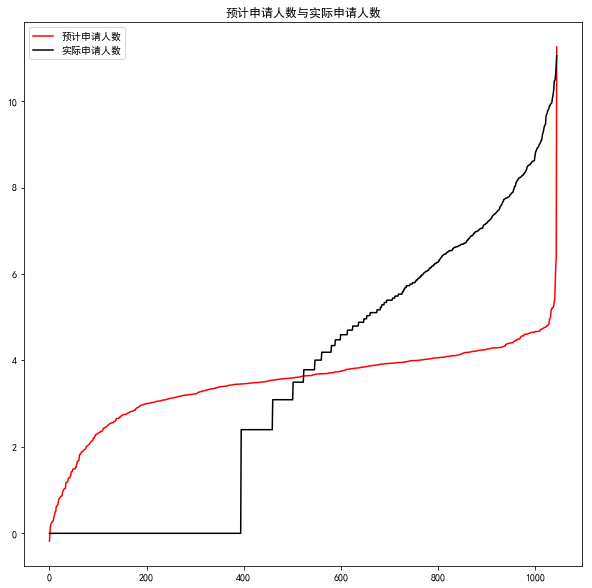

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(range(len(pred_y)),sorted(pred_y),c="red",label= "预计申请人数")
ax.plot(range(len(pred_y)),sorted(all_data1["申请人数"]),c="black",label = "实际申请人数")
ax.legend(loc='best')
plt.title('预计申请人数与实际申请人数')

In [24]:
# 计算RMSEA
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(pred_y, all_data1["申请人数"]))
rms

3.017409216877765

In [25]:
# 绘制偏回归线观察数据点是否分布在估计得到的直线的附近
# 图为控制了其他变量后，变量“name”对“申请人数”的回归关系）
## 莫名其妙的报错，在这个地方跑不出来

def PlotParialRP(name):
    ind = plot_names.index(name)
    plot_name = plot_names[:ind] + plot_names[ind + 1:]
    print(plot_name)
    sm.graphics.plot_partregress(
        endog = '申请人数',
        exog_i = '担保方式',
        exog_others = plot_names,
        data = data_plot, obs_labels=False)

#def PlotParialRP(name, all_data = all_data, plot_names = plot_names):
 #   ind = plot_names.index(name)
  #  plot_name = plot_names[:ind] + plot_names[ind + 1:]
   # sm.graphics.plot_partregress('申请人数',  name, plot_name, data = all_data, obs_labels = False)
#PlotParialRP('担保方式')

In [26]:
# 城市 还款方式 担保方式 贷款金额 期限 月管理费
# 当作绝对变量，对于每一个类型进行赋值
def processCate(data_list):
    data_set = list(set(data_list))
    data_dic = {}
    for i in range(len(data_set)):
        data_dic[data_set[i]] = i + 1
    return data_dic


def getNonnumDict(name):
    data_list = all_data[name].tolist()
    data_dict = processCate(data_list)
    return data_dict

In [27]:
cs_dict = getNonnumDict('城市')
hkfs_dict = getNonnumDict('还款方式')
dbfs_dict = getNonnumDict('担保方式')
dkje_dict = getNonnumDict('贷款金额')
qx_dict = getNonnumDict('期限')
yglf_dict = processCate(yglf_type)

In [28]:
# 得到所有的因变量
# 分类变量计数，目前没有用到
#cs_count = {}
#hkfs_count = {}
#dbfs_count = {}
cs_list = []
hkfs_list = []
dbje_list = []
dkje_list = []
qx_list = []
type_list = []

for row in all_data1.itertuples(index = True, name = 'Pandas'):
#    cs = getattr(row, '城市')
#    cs_count = getTextDict([cs], cs_count)
#    hkfs = getattr(row, '还款方式')
#    hkfs_count = getTextDict([hkfs], hkfs_count)
#    dbfs = getattr(row, '担保方式')
#    dbfs_count = getTextDict([dbfs], dbfs_count)

    
    cs_list.append(cs_dict[getattr(row, '城市')])
    hkfs_list.append(hkfs_dict[getattr(row, '还款方式')])
    dbje_list.append(dbfs_dict[getattr(row, '担保方式')])
    dkje_list.append(dkje_dict[getattr(row, '贷款金额')])
    qx_list.append(qx_dict[getattr(row, '期限')])
    type_list.append(yglf_dict[getattr(row, '月管理费类别')])


# 整合数据
all_data2 = all_data1.copy(deep=True)
all_data2['城市'] = cs_list
all_data2['还款方式'] = hkfs_list
all_data2['担保方式'] = dbje_list
all_data2['贷款金额'] = dkje_list
all_data2['期限'] = qx_list
all_data2['月管理费类别'] = type_list
all_data2['月管理费数额'] = yglf_num

月供


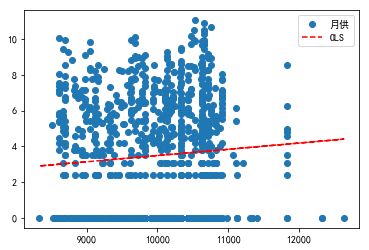

                            OLS Regression Results                            
Dep. Variable:                   申请人数   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     1274.
Date:                Sun, 24 Nov 2019   Prob (F-statistic):          4.40e-183
Time:                        16:52:44   Log-Likelihood:                -2687.9
No. Observations:                1046   AIC:                             5378.
Df Residuals:                    1045   BIC:                             5383.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
月供             0.0003   9.77e-06     35.693      0.0

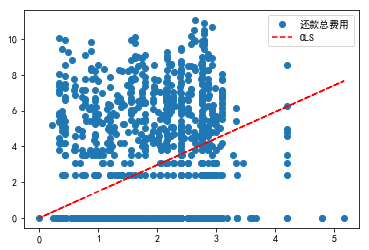

                            OLS Regression Results                            
Dep. Variable:                   申请人数   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     925.9
Date:                Sun, 24 Nov 2019   Prob (F-statistic):          3.80e-146
Time:                        16:52:44   Log-Likelihood:                -2772.9
No. Observations:                1046   AIC:                             5548.
Df Residuals:                    1045   BIC:                             5553.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
还款总费用          1.4820      0.049     30.429      0.0

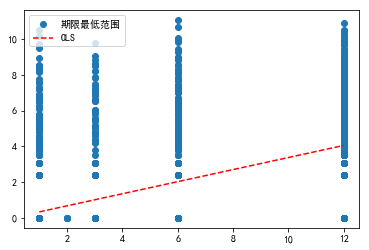

                            OLS Regression Results                            
Dep. Variable:                   申请人数   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     894.9
Date:                Sun, 24 Nov 2019   Prob (F-statistic):          1.54e-142
Time:                        16:52:44   Log-Likelihood:                -2781.2
No. Observations:                1046   AIC:                             5564.
Df Residuals:                    1045   BIC:                             5569.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
期限最低范围         0.3376      0.011     29.914      0.0

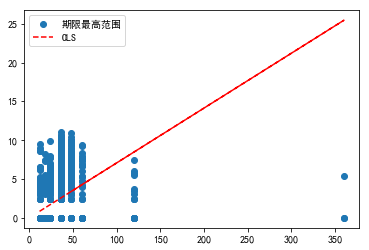

                            OLS Regression Results                            
Dep. Variable:                   申请人数   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     760.2
Date:                Sun, 24 Nov 2019   Prob (F-statistic):          3.43e-126
Time:                        16:52:45   Log-Likelihood:                -2818.9
No. Observations:                1046   AIC:                             5640.
Df Residuals:                    1045   BIC:                             5645.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
期限最高范围         0.0707      0.003     27.571      0.0

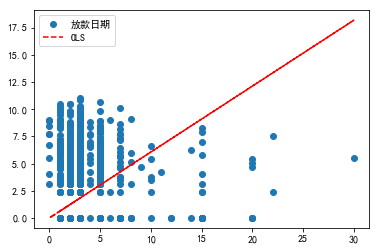

                            OLS Regression Results                            
Dep. Variable:                   申请人数   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                     508.7
Date:                Sun, 24 Nov 2019   Prob (F-statistic):           4.29e-92
Time:                        16:52:45   Log-Likelihood:                -2897.3
No. Observations:                1046   AIC:                             5797.
Df Residuals:                    1045   BIC:                             5802.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
放款日期           0.6058      0.027     22.554      0.0

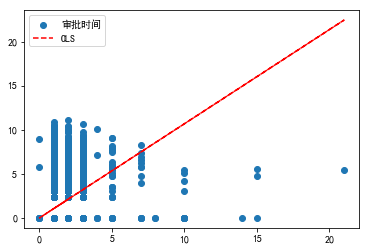

                            OLS Regression Results                            
Dep. Variable:                   申请人数   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     574.4
Date:                Sun, 24 Nov 2019   Prob (F-statistic):          1.63e-101
Time:                        16:52:45   Log-Likelihood:                -2875.7
No. Observations:                1046   AIC:                             5753.
Df Residuals:                    1045   BIC:                             5758.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
审批时间           1.0674      0.045     23.968      0.0

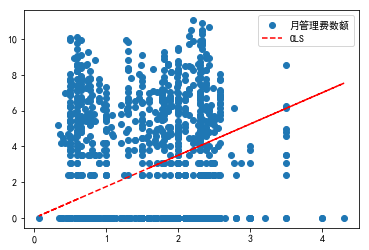

                            OLS Regression Results                            
Dep. Variable:                   申请人数   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     840.3
Date:                Sun, 24 Nov 2019   Prob (F-statistic):          4.65e-136
Time:                        16:52:45   Log-Likelihood:                -2796.2
No. Observations:                1046   AIC:                             5594.
Df Residuals:                    1045   BIC:                             5599.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
月管理费数额         1.7497      0.060     28.988      0.0

In [29]:
## 一个变量回归
y = all_data2['申请人数']

columns_num = [ '月供', '还款总费用', '期限最低范围',
               '期限最高范围',  '放款日期', '审批时间', '月管理费数额']

columns_nonnum = ['城市', '还款方式', '担保方式', '月管理费类别', '贷款金额', '期限']

columns_res = ['申请人数']


for name in columns_num:
    print(name)
    #print('\n')
    x = all_data1[name]
    lm = sm.OLS(y, x).fit()
    
    ## 画出图像
    plt.plot(x, y, 'o', label = name)
    plt.plot(x, lm.fittedvalues, 'r--', label="OLS")
    plt.legend(loc='best')
    plt.show()
    
    print(lm.summary())
    print('\n\n\n')
    

In [9]:
## 多元回归
num_lm = ols("""申请人数~ 月供 + 还款总费用 + 期限最低范围
                               + 期限最高范围 + 放款日期 + 审批时间 + 月管理费数额""",
                               data = all_data1).fit()

num_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   申请人数   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     6.381
Date:                Sun, 24 Nov 2019   Prob (F-statistic):           2.29e-07
Time:                        16:46:26   Log-Likelihood:                -2665.0
No. Observations:                1046   AIC:                             5346.
Df Residuals:                    1038   BIC:                             5386.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -38.7797     14.053     -2.760      0.006     -66.354     -11.205
月供             0.0050      0.002      2.949      0.003       0.002       0.008
还款总费用         -3.7388      1.439     -2.598      0.010      -6.562      -0.915
期限最低范围         0.0442      0.022      1.996      0.046       0.001       0.088
期限最高范围         0.0077      0.005      1.574      0.116      -0.002       0.017
放款日期          -0.2174      0.058     -3.729      0.000      -0.332      -0.103
审批时间           0.3812      0.091      4.179      0.000       0.202       0.560
月管理费数额        -0.4680      0.241     -1.946      0.052      -0.940       0.004
==============================================================================
Omnibus:                      503.756   Durbin-Watson:                   1.324
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.867
Skew:                           0.220   Prob(JB):                     8.21e-15
Kurtosis:                       1.862   Cond. No.                     1.47e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.47e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [328]:
all_data1.head()

,公司名称,城市,贷款金额,期限,月供,还款总费用,月管理费,期限最低范围,期限最高范围,还款方式,放款日期,审批时间,担保方式,申请人数,申请条件,月管理费类别,月管理费数额
0,中腾信金融信息服务（上海）有限公司北京分公司,1,1,1,9225,1.07,月管理费 1.60%,1,12,3,1,1.0,3,5.288267,北京牌照车辆、全款车、购买三个月以上1、名下有北京牌照车辆2、全款车、购买三个月以上3、信用...,3,1.6
1,北京森强国际投资担保有限公司,1,1,1,10046,2.06,月管理费 3.00%,1,120,2,1,1.0,1,3.784190,名下有车、北京牌照、有稳定还款来源1、名下有车2、北京牌照3、有稳定还款来源温馨提示：名下有...,3,3.0
2,北京博瑞奕华投资有限公司,1,1,1,9333,1.20,参考月利率 1.00%,1,36,3,3,1.0,3,5.730100,中国合法公民、18-60周岁、信用良好1、中国合法公民2、年龄在18-60岁3、具有完全民事...,2,1.0
3,北京博瑞奕华投资有限公司,1,1,1,8885,1.06,参考月利率 1.00%,1,12,2,15,10.0,1,0.000000,1、公司五证2、个人信息材料3、公司往来合同4、银行流水5、财务报表6、资产证明,2,1.0
4,北京中金行投资管理有限公司,1,1,1,9749,1.70,月管理费 2.50%,1,36,3,1,1.0,1,0.000000,1、身份证、户口本2、结婚证3、收入证明、房产证明或资产证明等,3,2.5


In [245]:
#进一步检验数据是不是适合使用OLS，
#我们暂且先检验一下数据是否为线性，虚无假设是线性的
#采用Rainbow test

print(sm.stats.linear_rainbow(mul_lm))

(1.0775851359834765, 0.19964787950948887)


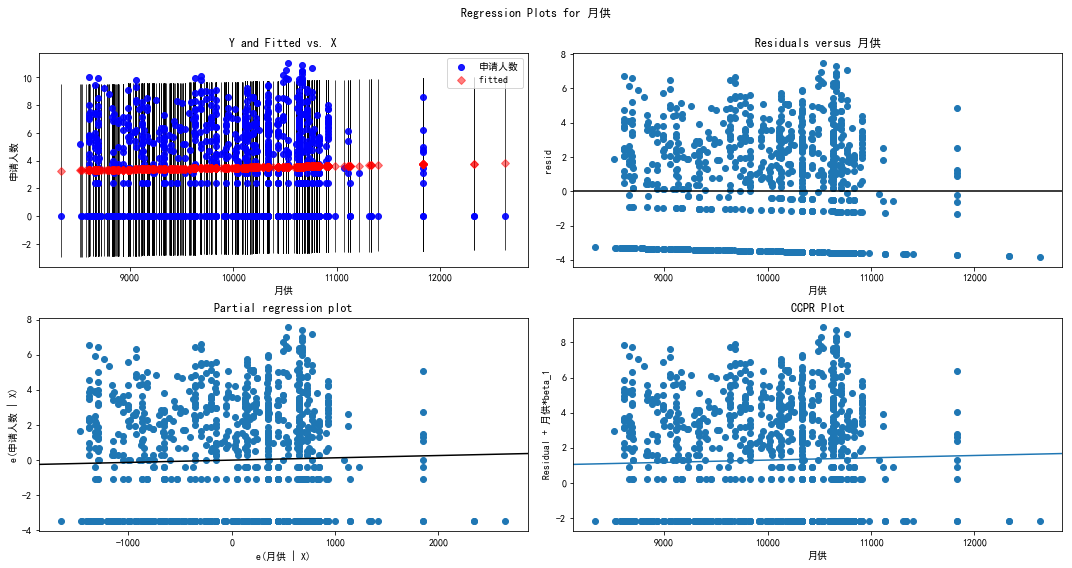

In [246]:
#训练模型
##一个自变量回归
one_lm = ols("""申请人数~ 月供""", data = all_data2).fit()


fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(one_lm, "月供", fig =fig)

#fig.savefig('./simple linear regression plots.jpg',dpi=300) #保存图片

In [257]:
# 前面的拟合结果很差，考虑加入更多的信息，也就是公司名称和申请条件

In [288]:
text = ''
for row in all_data.itertuples(index = True, name = 'Pandas'):
    sqtj = getattr(row, '申请条件')
    if type(sqtj) == str: 
        text = text + sqtj

In [305]:
## 使用textrank算法来获得关键词
sig_words = []
for x, w in analyse.extract_tags(text, topK = 10, withWeight = True, allowPOS = ('n','a')):
    sig_words.append((x, w * 10))
sig_words[:10]

[('流水', 4.041252613603013),
 ('信用', 3.876647959516885),
 ('良好', 3.1404292225120467),
 ('方可', 3.026180753908079),
 ('证明', 2.908314275896883),
 ('身份证', 2.054879240485313),
 ('记录', 1.9013970159794873),
 ('单位', 1.5857342239937244),
 ('名下', 1.4987341005066557),
 ('年龄', 1.3881523505780635)]

In [348]:
# 按照包含关键词的个数来进行打分
sqtj_list = all_data['申请条件']

scores = []
for i in range(len(sqtj_list)):
    sentence = sqtj_list[i]
    score = 0
    if type(sentence) == str:
        for word in sig_words:
            if word[0] in sentence:
                score = score + word[1]
    else:
        score = 0
    scores.append(score)
    
    
all_data3 = all_data1.copy(deep=True)
all_data3['申请条件分数'] = scores

In [352]:
## 多元回归
mul_lm3 = ols("""申请人数~ 月供 + 还款总费用 + 期限最低范围
                               + 期限最高范围 + 放款日期 + 审批时间 
                               + 城市 + 还款方式 + 担保方式 
                               + 月管理费类别 + 月管理费数额 + 申请条件分数""",
                               data = all_data3).fit()
mul_lm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   申请人数   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     5.868
Date:                Sun, 24 Nov 2019   Prob (F-statistic):           2.81e-18
Time:                        12:12:21   Log-Likelihood:                -191.91
No. Observations:                1046   AIC:                             437.8
Df Residuals:                    1019   BIC:                             571.5
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -2.2468      1.451     -1.548      0.122      -5.094       0.601
城市[T.北京]            0.0405      0.040      1.019      0.309      -0.038       0.119
城市[T.南京]           -0.0289      0.039     -0.745      0.456      -0.105       0.047
城市[T.天津]           -0.0356      0.048     -0.740      0.459      -0.130       0.059
城市[T.广州]            0.0228      0.040      0.577      0.564      -0.055       0.101
城市[T.成都]           -0.0529      0.039     -1.342      0.180      -0.130       0.024
城市[T.杭州]            0.1066      0.046      2.316      0.021       0.016       0.197
城市[T.济南]           -0.1069      0.047     -2.295      0.022      -0.198      -0.015
城市[T.深圳]           -0.0074      0.037     -0.200      0.841      -0.080       0.066
城市[T.西安]           -0.0303      0.042     -0.719      0.472      -0.113       0.052
城市[T.重庆]           -0.0488      0.043     -1.148      0.251      -0.132       0.035
城市[T.青岛]           -0.0637      0.044     -1.461      0.144      -0.149       0.022
还款方式[T.到期还款]       -0.0781      0.050     -1.561      0.119      -0.176       0.020
还款方式[T.随借随还]       -0.1311      0.090     -1.462      0.144      -0.307       0.045
担保方式[T.抵押贷]        -0.0711      0.033     -2.128      0.034      -0.137      -0.006
担保方式[T.担保贷]        -0.1224      0.151     -0.808      0.419      -0.420       0.175
担保方式[T.自由选]        -0.1448      0.060     -2.406      0.016      -0.263      -0.027
月管理费类别[T.参考月利率]    -0.0150      0.322     -0.047      0.963      -0.646       0.616
月管理费类别[T.月管理费]     -0.0394      0.318     -0.124      0.901      -0.663       0.584
月供                  0.0003      0.000      1.722      0.085   -4.04e-05       0.001
还款总费用              -0.2393      0.142     -1.685      0.092      -0.518       0.039
期限最低范围              0.0005      0.002      0.242      0.809      -0.004       0.005
期限最高范围              0.0006      0.000      1.268      0.205      -0.000       0.002
放款日期               -0.0186      0.006     -3.222      0.001      -0.030      -0.007
审批时间                0.0333      0.009      3.728      0.000       0.016       0.051
月管理费数额             -0.0035      0.031     -0.114      0.909      -0.064       0.057
申请条件分数              0.0174      0.002      7.400      0.000       0.013       0.022
==============================================================================
Omnibus:                      573.508   Durbin-Watson:                   1.456
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.376
Skew:                           0.149   Prob(JB):                     2.85e-14
Kurtosis:                       1.841   Cond. No.                     1.61e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correct

In [407]:
# 创建停用词列表
def stopwordslist():
    path = 'C:\\Users\WENDY\\Desktop\\消费者行为分析\\课业2019\\stop_words.txt'
    stopwords = [line.strip() for line in open(path).readlines()]
    return stopwords

In [408]:
# 对句子进行中文分词
def seg_depart(sentence, seg_list):
    # 对文档中的每一行进行中文分词
    if type(sentence) == int:
        sentence = ''
#    sentence_depart = jieba.cut(sentence.strip())
    sentence_depart = []
    sentence = pseg.cut(sentence.strip())
    for word, flag in sentence:
        if flag in seg_list:
            sentence_depart.append(word)
            
    # 创建一个停用词列表
    stopwords = stopwordslist()
    # 输出结果为outstr
    outstr = []
    # 去停用词
    for word in sentence_depart:
        if word not in stopwords:
            if word != '\t':
                # sqtj 1759, gsmc 384
                if len(word) != 1:
                    outstr.append(word)
    return outstr

In [409]:
def getTextDict(text_list, text_dict):
    for word in text_list:
        if word not in text_dict.keys():
            text_dict[word] = 1
        else:
            text_dict[word] = text_dict[word] + 1
    return text_dict

In [410]:
gsmc_dict = {}
for row in all_data.itertuples(index = True, name = 'Pandas'):
     
    gsmc = getattr(row, '公司名称')
    gsmc_seg_list = ['nt']
    gsmc_list = seg_depart(gsmc, gsmc_seg_list)
    gsmc_dict = getTextDict(gsmc_list, gsmc_dict)

print(gsmc_dict)

for name in gsmc_dict.keys():
    jieba.suggest_freq(name, True)

gsmc_new_dict = {}
for row in all_data.itertuples(index = True, name = 'Pandas'):
     
    gsmc = getattr(row, '公司名称')
    gsmc_seg_list = ['n']
    gsmc_list = seg_depart(gsmc, gsmc_seg_list)
    gsmc_list = [word for word in gsmc_list if word not in gsmc_dict.keys()]
    gsmc_new_dict = getTextDict(gsmc_list, gsmc_new_dict)
    
print(gsmc_new_dict)

{'商业银行': 4, '中信银行': 18, '招商银行': 2, '中国民生银行': 2, '民生银行': 6, '上海银行': 1, '商务信息': 12, '中国银行': 4, '北京分行': 15, '华夏银行': 12, '花旗银行': 20, '渣打银行': 4, '兴业银行': 2, '东亚银行': 1, '中国工商银行': 2, '中国光大银行': 1, '交通银行': 1, '中国农业银行': 3}
{'金融信息': 107, '有限公司': 795, '分公司': 414, '国际': 1, '金行': 2, '信息': 170, '小额贷款': 58, '平安保险': 43, '集团': 60, '股份': 81, '农村': 5, '汇润': 2, '银行': 89, '众信': 22, '商务': 35, '紫金': 6, '汇金': 15, '资产': 20, '金融': 22, '微贷': 6, '金融服务': 36, '帝臣': 1, '车融': 1, '融汇': 2, '冠群': 7, '服务公司': 2, '公司': 30, '银发': 2, '微金': 2, '领达': 3, '融金': 2, '新贷': 7, '基金': 3, '马铃薯': 4, '金易': 2, '网络科技': 3, '积木': 2, '时代': 42, '企业': 15, '小牛': 5, '资本': 5, '旺金': 1, '总公司': 3, '积家': 11, '国际金融': 2, '商业': 1, '办事处': 7, '速帮': 1, '财富': 29, '地产': 3, '信通': 6, '和益': 6, '汇融': 6, '邮政储蓄': 4, '信贷': 1, '速贷': 12, '创业投资': 1, '中盈富': 2, '信用': 1, '锦量': 4, '典知': 2, '金融中心': 6, '伟业': 1, '国腾': 2, '盈联': 3, '寰玥': 2, '金所': 3, '科技': 1, '中心': 1, '中资': 1, '合盘': 5, '银谷': 5, '分中心': 2, '互联网': 4, '世纪': 1, '贷款': 1, '汽车': 1, '善林': 2, '创富': 2, '文西': 1, '财产保险': 2, '八

In [420]:
# 一个好名字的影响
org_names = []
scarce_names = []
common_names = []

i = 1
weight = 50
for item in sorted(gsmc_dict.items(),key = lambda x:x[1],reverse = True):
    if i <= 50:
        org_names.append((item[0], weight))
        weight = weight - 1
        i = i + 1

i = 1
weight = 10
for item in sorted(gsmc_new_dict.items(),key = lambda x:x[1],reverse = True):
    if i <= 10:
        common_names.append((item[0], weight))
        weight = weight - 1
        i = i + 1

i = 1
weight = -10
for item in sorted(gsmc_new_dict.items(),key = lambda x:x[1],reverse = False):
    if i <= 10:
        scarce_names.append((item[0], weight))
        weight = weight + 1
        i = i + 1

print(org_names)
print(len(org_names))
print(common_names)
print(len(common_names))
print(scarce_names)
print(len(scarce_names))

[('花旗银行', 50), ('中信银行', 49), ('北京分行', 48), ('商务信息', 47), ('华夏银行', 46), ('民生银行', 45), ('商业银行', 44), ('中国银行', 43), ('渣打银行', 42), ('中国农业银行', 41), ('招商银行', 40), ('中国民生银行', 39), ('兴业银行', 38), ('中国工商银行', 37), ('上海银行', 36), ('东亚银行', 35), ('中国光大银行', 34), ('交通银行', 33)]
18
[('有限公司', 10), ('分公司', 9), ('信息', 8), ('金融信息', 7), ('银行', 6), ('股份', 5), ('集团', 4), ('小额贷款', 3), ('平安保险', 2), ('时代', 1)]
10
[('国际', -10), ('帝臣', -9), ('车融', -8), ('旺金', -7), ('商业', -6), ('速帮', -5), ('信贷', -4), ('创业投资', -3), ('信用', -2), ('伟业', -1)]
10


In [421]:
# 按照包含关键词的个数来进行打分
gsmc_list = all_data['公司名称']

org = []
for i in range(len(gsmc_list)):
    mz = gsmc_list[i]
    score = 0
    for word in org_names:
        if word[0] in mz:
                score = score + word[1]
    org.append(score)

common = []
for i in range(len(gsmc_list)):
    mz = gsmc_list[i]
    score = 0
    for word in common_names:
        if word[0] in mz:
                score = score + word[1]
    common.append(score)

scarce = []
for i in range(len(gsmc_list)):
    mz = gsmc_list[i]
    score = 0
    for word in scarce_names:
        if word[0] in mz:
                score = score + word[1]
    scarce.append(score)

    
all_data4 = all_data3.copy(deep = True)
all_data4['大机构'] = org
all_data4['常见词'] = common
all_data4['稀有词'] = scarce
all_data4.head()

,公司名称,城市,贷款金额,期限,月供,还款总费用,月管理费,期限最低范围,期限最高范围,还款方式,...,审批时间,担保方式,申请人数,申请条件,月管理费类别,月管理费数额,申请条件分数,大机构,常见词,稀有词
0,中腾信金融信息服务（上海）有限公司北京分公司,北京,10万元,12月,9225,1.07,月管理费 1.60%,1,12,分期还款,...,1.0,信用贷,0.510120,北京牌照车辆、全款车、购买三个月以上1、名下有北京牌照车辆2、全款车、购买三个月以上3、信用...,月管理费,1.6,8.515811,0,34,0
1,北京森强国际投资担保有限公司,北京,10万元,12月,10046,2.06,月管理费 3.00%,1,120,到期还款,...,1.0,抵押贷,0.285804,名下有车、北京牌照、有稳定还款来源1、名下有车2、北京牌照3、有稳定还款来源温馨提示：名下有...,月管理费,3.0,4.524915,0,10,-10
2,北京博瑞奕华投资有限公司,北京,10万元,12月,9333,1.20,参考月利率 1.00%,1,36,分期还款,...,1.0,信用贷,0.557174,中国合法公民、18-60周岁、信用良好1、中国合法公民2、年龄在18-60岁3、具有完全民事...,参考月利率,1.0,11.431410,0,10,0
3,北京博瑞奕华投资有限公司,北京,10万元,12月,8885,1.06,参考月利率 1.00%,1,12,到期还款,...,10.0,抵押贷,0.000000,1、公司五证2、个人信息材料3、公司往来合同4、银行流水5、财务报表6、资产证明,参考月利率,1.0,6.949567,0,10,0
4,北京中金行投资管理有限公司,北京,10万元,12月,9749,1.70,月管理费 2.50%,1,36,分期还款,...,1.0,抵押贷,0.000000,1、身份证、户口本2、结婚证3、收入证明、房产证明或资产证明等,月管理费,2.5,4.963194,0,10,0


In [422]:
## 多元回归
mul_lm4 = ols("""申请人数~ 月供 + 还款总费用 + 期限最低范围
                               + 期限最高范围 + 放款日期 + 审批时间 
                               + 城市 + 还款方式 + 担保方式 
                               + 月管理费类别 + 月管理费数额 + 申请条件分数
                               + 大机构 + 常见词 + 稀有词""",
             data = all_data4).fit()

mul_lm4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   申请人数   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     6.090
Date:                Sun, 24 Nov 2019   Prob (F-statistic):           5.77e-21
Time:                        12:53:53   Log-Likelihood:                -181.05
No. Observations:                1046   AIC:                             422.1
Df Residuals:                    1016   BIC:                             570.7
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.1559      1.460     -0.792      0.429      -4.020       1.708
城市[T.北京]            0.0211      0.040      0.529      0.597      -0.057       0.099
城市[T.南京]           -0.0235      0.039     -0.609      0.543      -0.099       0.052
城市[T.天津]           -0.0348      0.048     -0.728      0.467      -0.128       0.059
城市[T.广州]            0.0225      0.039      0.571      0.568      -0.055       0.100
城市[T.成都]           -0.0501      0.039     -1.277      0.202      -0.127       0.027
城市[T.杭州]            0.1085      0.046      2.375      0.018       0.019       0.198
城市[T.济南]           -0.1089      0.047     -2.335      0.020      -0.200      -0.017
城市[T.深圳]            0.0001      0.037      0.003      0.997      -0.073       0.073
城市[T.西安]           -0.0256      0.042     -0.610      0.542      -0.108       0.057
城市[T.重庆]           -0.0447      0.042     -1.056      0.291      -0.128       0.038
城市[T.青岛]           -0.0632      0.044     -1.453      0.147      -0.149       0.022
还款方式[T.到期还款]       -0.0713      0.050     -1.433      0.152      -0.169       0.026
还款方式[T.随借随还]       -0.1381      0.089     -1.553      0.121      -0.313       0.036
担保方式[T.抵押贷]        -0.0663      0.034     -1.973      0.049      -0.132      -0.000
担保方式[T.担保贷]        -0.1292      0.151     -0.854      0.393      -0.426       0.168
担保方式[T.自由选]        -0.1189      0.060     -1.969      0.049      -0.237      -0.000
月管理费类别[T.参考月利率]    -0.1154      0.319     -0.361      0.718      -0.742       0.511
月管理费类别[T.月管理费]     -0.0948      0.315     -0.301      0.764      -0.713       0.524
月供                  0.0002      0.000      0.968      0.333      -0.000       0.000
还款总费用              -0.1207      0.143     -0.842      0.400      -0.402       0.160
期限最低范围              0.0012      0.002      0.536      0.592      -0.003       0.006
期限最高范围              0.0008      0.000      1.651      0.099      -0.000       0.002
放款日期               -0.0208      0.006     -3.627      0.000      -0.032      -0.010
审批时间                0.0326      0.009      3.673      0.000       0.015       0.050
月管理费数额             -0.0083      0.031     -0.269      0.788      -0.069       0.052
申请条件分数              0.0175      0.002      7.523      0.000       0.013       0.022
大机构                 0.0031      0.001      4.444      0.000       0.002       0.004
常见词                -0.0009      0.001     -0.724      0.469      -0.003       0.001
稀有词                 0.0065      0.011      0.576      0.565      -0.016       0.029
==============================================================================
Omnibus:                      437.547   Durbin-Watson:                   1.461
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.741
Skew:                           0.138   Prob(JB):                     2.90

In [423]:
## 多元回归
mul_lm5 = ols("""申请人数~ 大机构 + 常见词 + 稀有词""", data = all_data4).fit()

mul_lm5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   申请人数   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     7.918
Date:                Sun, 24 Nov 2019   Prob (F-statistic):           3.18e-05
Time:                        12:54:14   Log-Likelihood:                -253.09
No. Observations:                1046   AIC:                             514.2
Df Residuals:                    1042   BIC:                             534.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2759      0.021     13.016      0.000       0.234       0.318
大机构            0.0030      0.001      4.609      0.000       0.002       0.004
常见词            0.0001      0.001      0.109      0.913      -0.002       0.002
稀有词            0.0136      0.012      1.177      0.239      -0.009       0.036
==============================================================================
Omnibus:                     7811.199   Durbin-Watson:                   1.351
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.459
Skew:                           0.215   Prob(JB):                     2.07e-23
Kurtosis:                       1.513   Cond. No.                         42.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""